<a href="https://colab.research.google.com/github/spanman888/DSC672_Teacher_Salary/blob/master/Capstone_Teacher_Salary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import os
import numpy as np

from sklearn.model_selection import cross_validate, train_test_split 
from sklearn.linear_model import LinearRegression

pd.set_option('display.max_columns', 100)

In [2]:
# In order to download files to local file system
from google.colab import drive
drive.mount('drive')



Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [0]:
#Load teacher data from GitHub
url2003 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2003_tsr_public_dataset.csv'
url2004 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2004_tsr_public_dataset.csv'
url2005 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2005_tsr_public_dataset.csv'
url2006 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2006_tsr_public_dataset.csv'
url2007 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2007_tsr_public_dataset.csv'
url2008 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2008_tsr_public_dataset.csv'
url2009 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2009_tsr_public_dataset.csv'
url2010 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2010_tsr_public_dataset.csv'
url2011 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2011_tsr_public_dataset.csv'
url2012 = 'https://raw.githubusercontent.com/spanman888/DSC672_Teacher_Salary/master/DSC672_Data/2012-tsr-public-dataset.csv'

#Load inflation data from GitHub
inflation_GitHub = 'https://github.com/spanman888/DSC672_Teacher_Salary/blob/master/DSC672_Data/CPIAUCNS_2003_2019.xls?raw=true'

In [4]:
#Combine all teacher data into one dataframe
df = pd.concat(map(pd.read_csv, [url2003, url2004,url2005,url2006,url2007,url2008,url2009,url2010,url2011,url2012]))

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (7,34,38) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,7,8,14) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
#Count number of records for all variables
df.count()

fy                     1624887
rcdt                   1624887
dst_name               1624846
dst_addr               1624846
dst_city               1624846
dst_st                 1624846
dst_zip                1624846
dst_zip_plus4          1624846
sch_num                1624887
sch_name               1624866
sch_addr               1503783
sch_city               1503783
sch_st                 1503783
sch_zip                1503783
sch_zip_plus4          1503783
last_name              1624887
first_name             1624887
mid_init               1624887
gender                 1624887
race_ethnicity_cd      1624559
race_ethnicity_desc    1624468
tsr_status_cd          1624887
tsr_status_desc        1624887
location_cd            1624878
location_desc          1624833
emply_type             1624887
emply_desc             1624665
salary                 1624887
months_employed        1624887
pct_emp                1624887
                        ...   
dist_exp               1624887
state_ex

In [0]:
#moving salary to first column
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('salary')))
cols

df = df.reindex(columns= cols)

In [0]:
#Create column with first three of zip
df['first_3'] = df['dst_zip'].astype(str).str[0:3]

#Assign suburb zips to a list
suburb = ['600','601','603','604','605','607','608']

#Create new Zip_Type column and assign based on first three of zip or where city is Chicago
#A suburb is any first three of ZIP that touches the 606XX zip code and is not Chicago
df['Zip_Type'] = np.where(df["first_3"].isin(suburb), "Suburb", "Other")
df['Zip_Type'] = np.where(df["dst_city"] == 'Chicago', 'Chicago', df["Zip_Type"])

In [8]:
print(df['Zip_Type'].value_counts())

Suburb     790630
Other      558018
Chicago    276239
Name: Zip_Type, dtype: int64


In [0]:
#Loading inflation data
inflation = pd.read_excel(inflation_GitHub, sheet_name='FRED Graph')

#Indexing inflation to latest value in data (2019 data)
inflation['CPI_Multiplier'] = inflation['CPIAUCNS'].iloc[-1] / inflation['CPIAUCNS']

#Breaking out year and date columns
inflation['year'] = inflation['observation_date'].dt.year
inflation['month'] = inflation['observation_date'].dt.month

#Only keeping Jan 1 values for each year
inflation = inflation[inflation['month'] == 1]

#Only keeping CPI Multiplier and year
inflation = inflation.drop(['observation_date','CPIAUCNS', 'month'], axis=1)

#Matching column names with data
inflation.columns = ['CPI_Multiplier', 'fy']

# merge dataframe
df = pd.merge(df, inflation, how='left', on='fy')

#Inflation adjusting salary by multiplying salary by CPI Multiplier
df['CPIAdjSalary'] = df['salary'] * df['CPI_Multiplier'] 


In [0]:
#Adding Inflation Adjusted Salary per Month
df['AdjSalMonth'] = df['CPIAdjSalary'] / df['months_employed'] 

#Adding Non-Inflation Adjusted Salary per Month
df['SalMonth'] = df['salary'] / df['months_employed'] 

In [0]:
#moving CPIAdjSalary to first column
cols = df.columns.tolist()
cols.insert(0, cols.pop(cols.index('CPIAdjSalary')))
cols

df = df.reindex(columns= cols)


In [0]:
#removing assignment_4 thru assign7_desc variables; tsr_status variables; state variables; teacher names columns

df = df.drop(['assignment_4', 'assign4_desc', 'assignment_5','assign5_desc','assignment_6','assign6_desc','assignment_7','assign7_desc', 'dst_st', 'sch_st','tsr_status_cd', 'tsr_status_desc', 'mid_init','last_name','first_name'], axis=1)


In [0]:
#removing info on specific bachelor/advanced degree schools
df = df.drop(['bacc_coll','bacc_coll_desc','adv_coll','adv_coll_desc'],axis=1)


In [0]:
#creating variables denoting 2 or 3 assignments
def assign(x):
    if x > 0:
      return 1
    else:
      return 0

df["multi_assign_2"] = df["assignment_2"].apply(assign)
df["multi_assign_3"] = df["assignment_3"].apply(assign)

In [0]:
#removing assignment_2 and assignment_3 variables
df = df.drop(['assignment_2','assign2_desc','assignment_3','assign3_desc'],axis=1)

In [0]:
#removing pct_emp varialbe - same values as fte; also removing emply_type
df = df.drop(['pct_emp', 'emply_type'],axis=1)

In [0]:
#removing zip code + 4 features variable - postal route not useful for analysis
df = df.drop(['dst_zip_plus4'],axis=1)

In [18]:
!pip install missingno
import missingno as msno

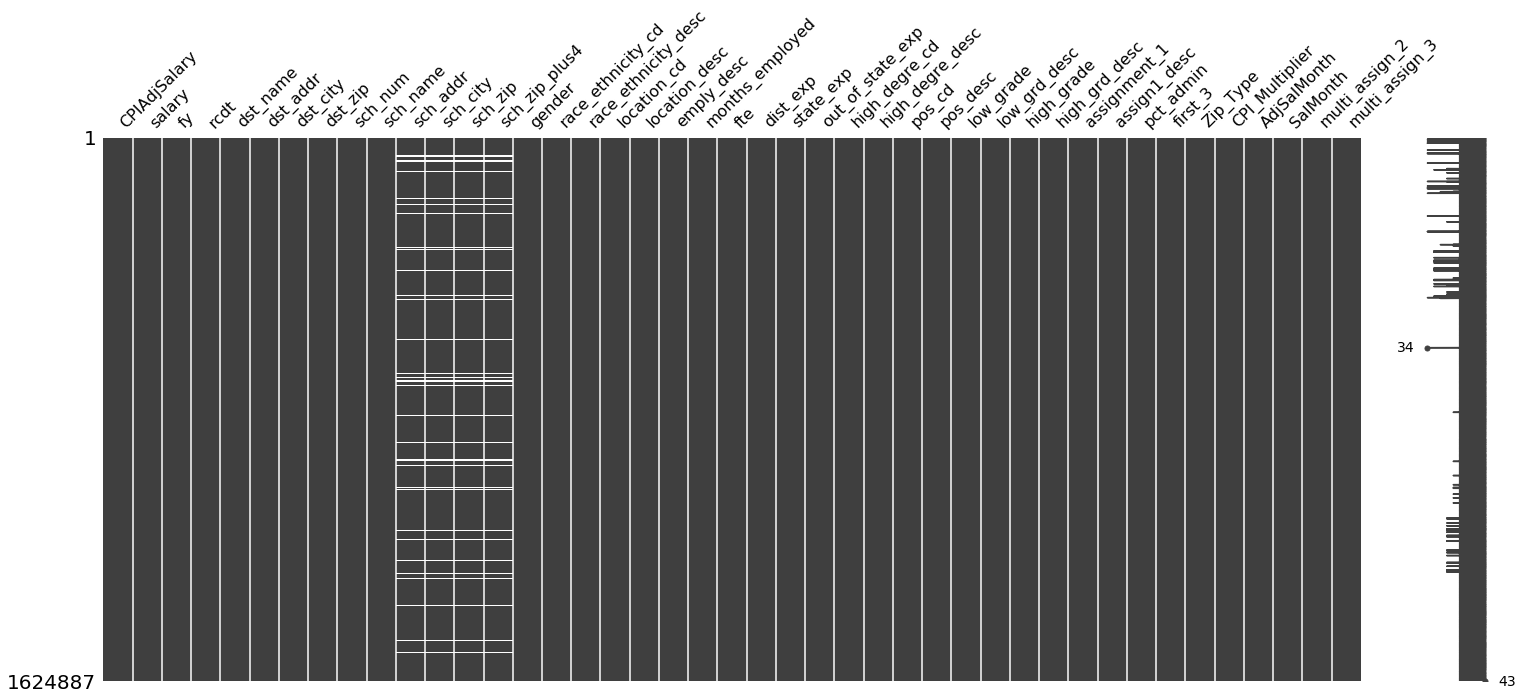

In [19]:
msno.matrix(df)

This shows that most of the missing data are in the school location columns. There doesn't seem to be a pattern of the missing values. The highest amount of missing variables is 7 for a particular (out of 39 possible variables at this point).

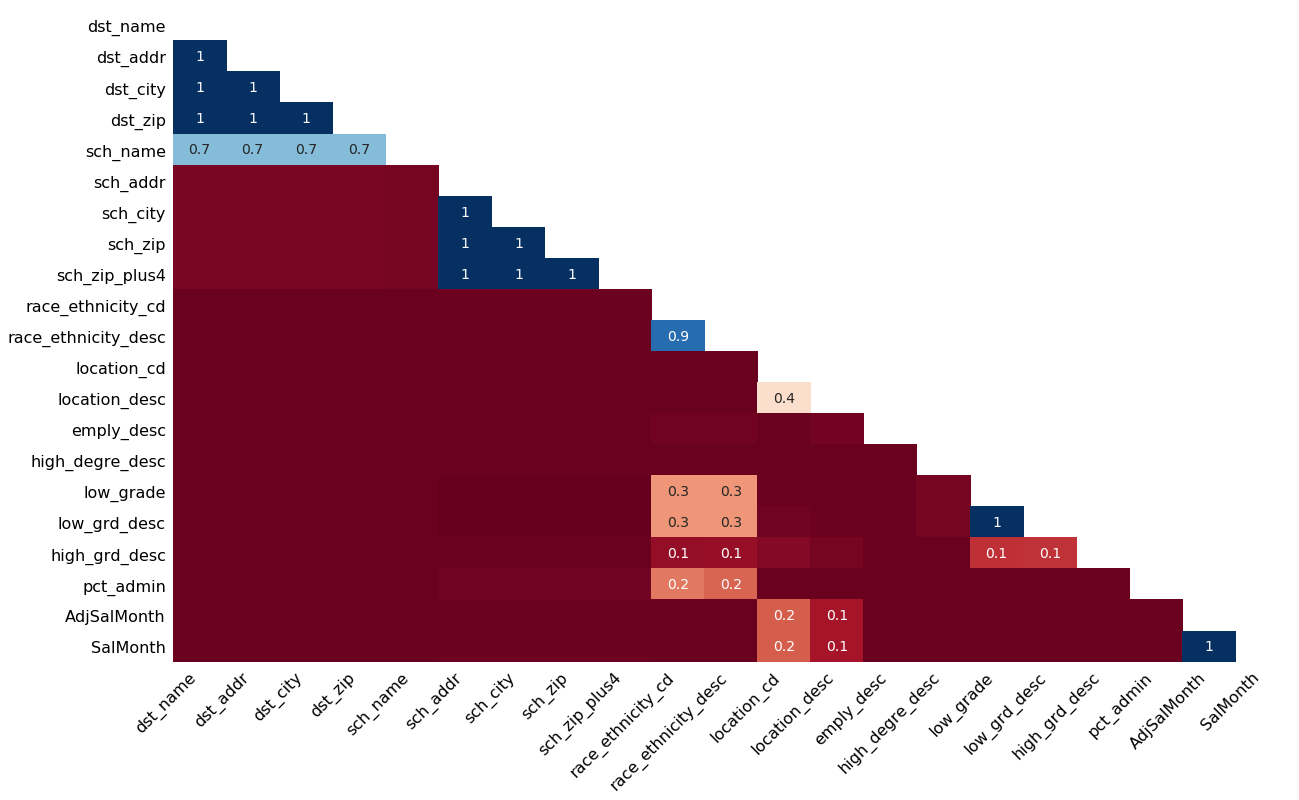

In [20]:
#Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) 
#to 1 (if one variable appears the other definitely also does).
msno.heatmap(df)

The above suggests that when there is some district information there is all district information. There is also a slight correlation between having the low grade variable and race ethnicity information. There doesn't seem to be much correlation between other missing variables. Both of these plots suggest we can remove missing variables as there are not clear patterns to the missing data and we have enough full records. 

In [0]:
#dropping all rows with NA values
df = df.dropna()

In [22]:
#row count
df.shape

(1501683, 43)

In [0]:
#Calculate Z-Scores for Adjusted Salary per Month and add as a column
from scipy import stats
df['z_score'] = np.abs(stats.zscore(df['AdjSalMonth']))

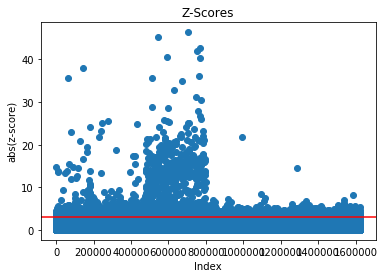

In [24]:
import matplotlib.pyplot as plt
plt.scatter(x=df.index, y='z_score', data=df)
plt.title('Z-Scores')
plt.ylabel('abs(z-score)')
plt.xlabel('Index')
plt.axhline(y=3, color='red')
plt.show()

In [25]:
#Outliers are where absolute value of z-score > 3 or salary is equal to 0
df_outliers = df[(df["z_score"] > 3 ) | (df["salary"] < 1 )]
df_outliers.describe()

,CPIAdjSalary,salary,fy,dst_zip,sch_zip,months_employed,fte,dist_exp,state_exp,out_of_state_exp,high_degre_cd,pos_cd,assignment_1,pct_admin,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score
count,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000,13537.000000
mean,112798.228419,89729.864534,2007.910615,60477.888454,60482.227229,9.131418,89.176996,19.150395,23.283187,0.573879,4.850632,22.782965,155.551082,17.597843,1.237857,13441.675033,10672.540803,0.260767,0.077270,3.711058
std,82290.217929,65819.585095,2.825838,659.185779,655.251382,2.208563,25.218560,12.152799,11.868240,2.243821,0.549418,11.207440,144.452174,36.840434,0.086886,11120.624880,8788.316107,0.439069,0.267029,2.435648
min,0.000000,0.000000,2003.000000,60002.000000,60002.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.121488,0.000000,0.000000,0.000000,0.000000,2.837603
25%,0.000000,0.000000,2006.000000,60067.000000,60068.000000,9.000000,100.000000,7.000000,14.000000,0.000000,5.000000,19.000000,36.000000,0.000000,1.173130,0.000000,0.000000,0.000000,0.000000,2.837605
50%,156168.423657,122778.000000,2008.000000,60201.000000,60201.000000,10.000000,100.000000,20.000000,28.000000,0.000000,5.000000,22.000000,97.000000,0.000000,1.204292,16837.648435,13253.632222,0.000000,0.000000,3.185102
75%,172733.827711,140390.000000,2010.000000,60521.000000,60525.000000,10.000000,100.000000,31.000000,33.000000,0.000000,5.000000,22.000000,220.000000,0.000000,1.281906,17975.960437,14660.292000,1.000000,0.000000,3.592268
max,566105.161997,441612.000000,2012.000000,62995.000000,62995.000000,12.000000,100.000000,57.000000,57.000000,34.000000,6.000000,64.000000,606.000000,100.000000,1.399020,137608.709223,109575.080000,1.000000,1.000000,46.384051


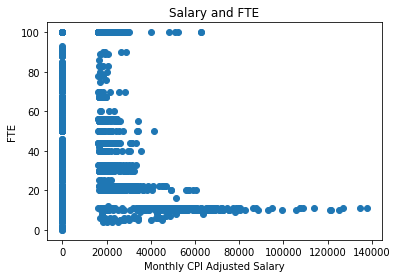

In [26]:
import matplotlib.pyplot as plt
plt.scatter(x=df_outliers.AdjSalMonth, y=df_outliers.fte, data=df_outliers)
plt.title('Salary and FTE')
plt.ylabel('FTE')
plt.xlabel('Monthly CPI Adjusted Salary')
plt.show()

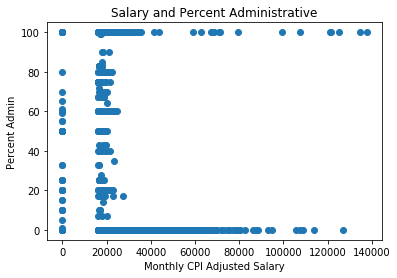

In [27]:
import matplotlib.pyplot as plt
plt.scatter(x=df_outliers.AdjSalMonth, y=df_outliers.pct_admin, data=df_outliers)
plt.title('Salary and Percent Administrative')
plt.ylabel('Percent Admin')
plt.xlabel('Monthly CPI Adjusted Salary')
plt.show()

There is a high percentage of outliers at both 0 and 100% administrative.

In [28]:
df_not_outliers= df[(df["z_score"] < 3) & (df["salary"] != 0)]
df_not_outliers.describe()

,CPIAdjSalary,salary,fy,dst_zip,sch_zip,months_employed,fte,dist_exp,state_exp,out_of_state_exp,high_degre_cd,pos_cd,assignment_1,pct_admin,CPI_Multiplier,AdjSalMonth,SalMonth,multi_assign_2,multi_assign_3,z_score
count,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06,1.488147e+06
mean,7.474501e+04,6.019124e+04,2.007532e+03,6.087249e+04,6.087906e+04,9.435126e+00,9.804774e+01,1.112772e+01,1.312152e+01,3.771854e-01,4.577520e+00,2.098699e+01,1.554987e+02,4.783406e+00,1.248923e+00,7.882961e+03,6.346194e+03,2.292583e-01,6.688990e-02,7.340556e-01
std,2.631542e+04,2.174742e+04,2.868470e+00,8.320505e+02,8.298823e+02,7.791654e-01,9.750320e+00,9.228558e+00,9.677152e+00,1.847879e+00,5.410396e-01,7.478017e+00,1.686231e+02,2.107611e+01,8.981493e-02,2.546298e+03,2.106253e+03,4.203558e-01,2.498313e-01,5.394686e-01
min,4.692520e-02,4.000000e-02,2.003000e+03,4.837500e+04,6.000200e+04,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.121488e+00,4.692520e-03,4.000000e-03,0.000000e+00,0.000000e+00,3.333559e-07
25%,5.551030e+04,4.432900e+04,2.005000e+03,6.018500e+04,6.018700e+04,9.000000e+00,1.000000e+02,4.000000e+00,5.000000e+00,0.000000e+00,4.000000e+00,1.900000e+01,3.700000e+01,0.000000e+00,1.173130e+00,5.985044e+03,4.789100e+03,0.000000e+00,0.000000e+00,3.269198e-01
50%,7.010771e+04,5.651740e+04,2.008000e+03,6.060300e+04,6.061000e+04,9.000000e+00,1.000000e+02,8.000000e+00,1.100000e+01,0.000000e+00,5.000000e+00,1.900000e+01,5.900000e+01,0.000000e+00,1.204292e+00,7.517495e+03,6.056542e+03,0.000000e+00,0.000000e+00,6.433467e-01
75%,9.077365e+04,7.298900e+04,2.010000e+03,6.135300e+04,6.135300e+04,1.000000e+01,1.000000e+02,1.600000e+01,1.900000e+01,0.000000e+00,5.000000e+00,2.200000e+01,2.230000e+02,0.000000e+00,1.332994e+00,9.504519e+03,7.658442e+03,0.000000e+00,0.000000e+00,1.006069e+00
max,1.958181e+05,1.743640e+05,2.012000e+03,6.299900e+04,6.299900e+04,1.500000e+01,1.000000e+02,6.300000e+01,6.300000e+01,4.500000e+01,6.000000e+00,6.500000e+01,6.070000e+02,1.000000e+02,1.399020e+00,1.632011e+04,1.455220e+04,1.000000e+00,1.000000e+00,2.999983e+00


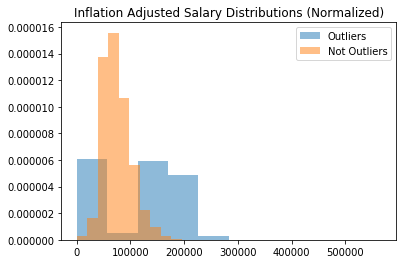

In [29]:
x = [df_outliers['CPIAdjSalary']]
y = [df_not_outliers['CPIAdjSalary']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('Inflation Adjusted Salary Distributions (Normalized)')
plt.show()

We see again the large amount of outliers at 0 and above 100000 (inflation adjusted)

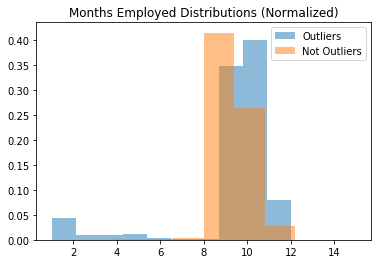

In [30]:
x = [df_outliers['months_employed']]
y = [df_not_outliers['months_employed']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('Months Employed Distributions (Normalized)')
plt.show()

Outliers have more at 0 - 5 months employed as well as 12 months. 

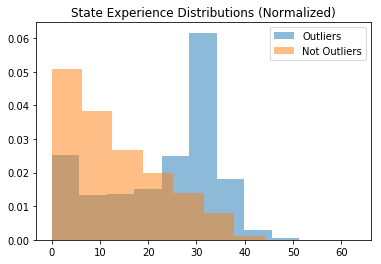

In [31]:
x = [df_outliers['state_exp']]
y = [df_not_outliers['state_exp']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('State Experience Distributions (Normalized)')
plt.show()

Outliers skew much higher for In State Experience with many over 30 year. 

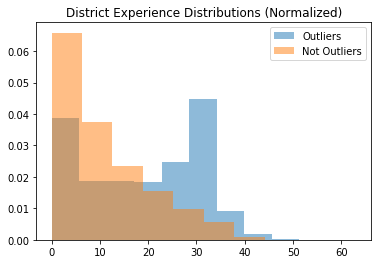

In [32]:
x = [df_outliers['dist_exp']]
y = [df_not_outliers['dist_exp']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper right')
plt.title('District Experience Distributions (Normalized)')
plt.show()

Again we see much more discrict experience with the outliers. 

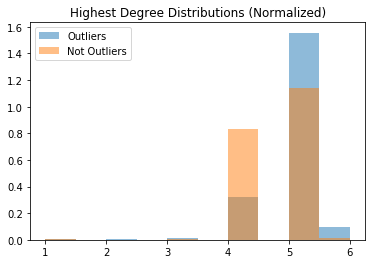

In [33]:
x = [df_outliers['high_degre_cd']]
y = [df_not_outliers['high_degre_cd']]

plt.hist(x, alpha=0.5, label='Outliers', density = True)
plt.hist(y, alpha=0.5, label='Not Outliers', density = True)
plt.legend(loc='upper left')
plt.title('Highest Degree Distributions (Normalized)')
plt.show()

Outliers have more education themselves. 

In [0]:
#Filter only where z_score of adjusted salary per month is less than 3 (standard deviations) and salary not equal to 0
df = df[(df["z_score"] < 3) & (df["salary"] > 0)]

In [35]:
#We removed 13549 records
df.shape

(1488147, 44)

In [36]:
print(df['gender'].value_counts())
print(df['high_degre_desc'].value_counts())
print(df['race_ethnicity_desc'].value_counts())
print(df['location_cd'].value_counts())
print(df['location_desc'].value_counts())
print(df['Zip_Type'].value_counts())

F    1140194
M     347952
           1
Name: gender, dtype: int64
Masters                                   849349
Baccalaureate                             620509
Doctorate                                  11876
None                                        3466
C.A.S., Specialist, 6 Year Certificate      2626
Registered Nurse                             321
Name: high_degre_desc, dtype: int64
White, Non-Hispanic                          1013516
White                                         249739
Black, Non-Hispanic                           107756
Hispanic                                       52429
Black or African American                      22347
Hispanic or Latino                             14944
Asian or Pacific Islander                      13466
Unknown                                         5505
Asian                                           3572
Two or More Races                               2245
American Indian or Alaskan Native               1895
American Indian or Al

Text(0.5, 1.0, 'Correlation Heat Map of Original Data Set')

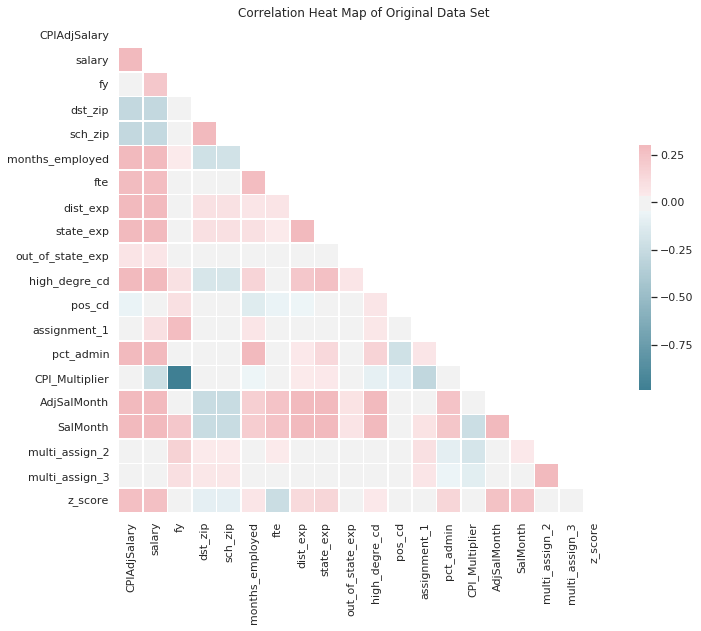

In [37]:
#Generate Correlation Heat Map for Original Data
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a large random dataset
rs = np.random.RandomState(33)


# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title('Correlation Heat Map of Original Data Set')

In [38]:
#dropping row where gender is ' '
df = df.drop(df[df.gender==' '].index)
df.shape

(1488146, 44)

In [39]:
print(df['gender'].value_counts())

F    1140194
M     347952
Name: gender, dtype: int64


Text(0.5, 1.0, 'Distribution of Adjusted Monthly Salary by Gender')

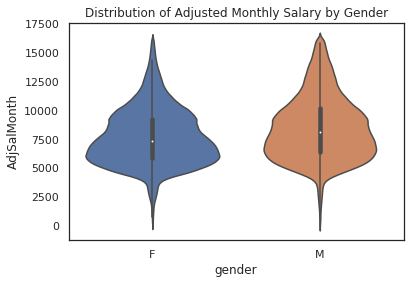

In [40]:
sns.violinplot(x='gender', y='AdjSalMonth', data=df).set_title('Distribution of Adjusted Monthly Salary by Gender')

In [0]:
#grouping ethnicities
def eth_assign(x):
    if x == 'White' or x == 'White, Non-Hispanic':
      return 'White'
    elif x == 'Black' or x == 'Black, Non-Hispanic' or x == 'Black or African American':
      return 'Black'
    elif x == 'Hispanic' or x == 'Hispanic or Latino':
      return 'Hispanic'
    elif x == 'Asian or Pacific Islander' or x == 'Native Hawaiian or Other Pacific Islander' or x == 'Asian':
      return 'Asian or Pacific Islander'
    elif x == 'American Indian or Alaska Native' or x == 'American Indian or Alaskan Native':
      return 'American Indian or Alaska Native'
    else:
      return 'Unknown'
       

df["eth_groups"] = df["race_ethnicity_desc"].apply(eth_assign)

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text xticklabel objects>)

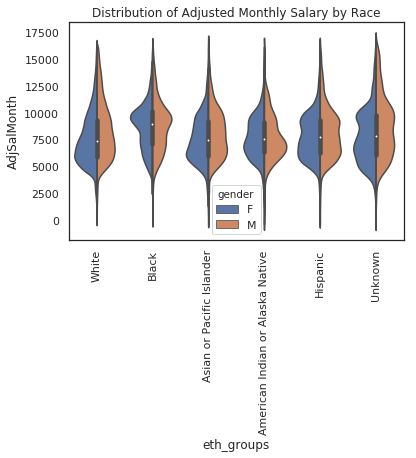

In [42]:
sns.violinplot(x='eth_groups', y='AdjSalMonth', data=df, hue='gender', split=True).set_title('Distribution of Adjusted Monthly Salary by Race')
plt.xticks(rotation=90)

In [0]:
#grouping education level
def edu_assign(x):
    if x == 'Masters':
      return 'Masters'
    elif x == 'Baccalaureate':
      return 'Bachelors'
    elif x == 'Doctorate':
      return 'Doctorate'
    elif x == 'None':
      return 'None'
    else:
      return 'Other'
       

df["edu_groups"] = df["high_degre_desc"].apply(edu_assign)

In [44]:
#checking counts for each
print(df['eth_groups'].value_counts())
print(df['edu_groups'].value_counts())

White                               1263255
Black                                130103
Hispanic                              67373
Asian or Pacific Islander             17292
Unknown                                7749
American Indian or Alaska Native       2374
Name: eth_groups, dtype: int64
Masters      849349
Bachelors    620509
Doctorate     11876
None           3465
Other          2947
Name: edu_groups, dtype: int64


In [0]:
#deleting original ethnicity, education, and location_cd columns - no longer needed for analysis
df = df.drop(['high_degre_cd', 'high_degre_desc', 'race_ethnicity_cd', 'race_ethnicity_desc', 'location_cd'],axis=1)

Text(0.5, 1.0, 'Distribution of Adjusted Monthly Salary by Education Level')

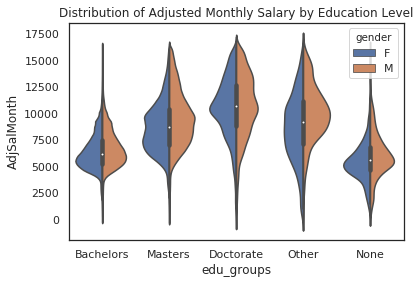

In [46]:
sns.violinplot(x='edu_groups', y='AdjSalMonth', data=df, hue='gender', split=True).set_title('Distribution of Adjusted Monthly Salary by Education Level')

In [47]:
print(df['pos_desc'].value_counts())

Elementary Teacher                     562004
High School Teacher                    335908
Junior High/Middle Teacher             204296
Special Education Teacher              184708
Guidance Counselor                      29967
Elementary Principal                    22530
Social Worker                           21812
Librarian/Media Specialist              19907
Speech/Language Pathologist             17742
Assistant Elementary Principal           9245
Psychologist                             9088
Reading Specialist                       8389
Assistant High School Principal          7794
High School Principal                    6456
Nurse                                    6450
Junior High/Middle Principal             5722
Kindergarten                             5628
Assistant Jr High/Middle Principal       5002
Director                                 3621
Student Dean                             3551
Coordinator                              3424
Program Supervisor                

In [48]:
#removing non-teacher cases by creating variable of those to drop
def pos_drop(x):
    if x == 18:
      return 1
    elif x == 19:
      return 1
    elif x == 20: 
      return 1
    elif x == 22: 
      return 1
    elif x == 63:
      return 1
    elif x == 64: 
      return 1
    else:
      return 0

df["pos_drop"] = df["pos_cd"].apply(pos_drop) 
print(df['pos_drop'].value_counts())

1    1295444
0     192702
Name: pos_drop, dtype: int64


In [49]:
# Delete these rows from dataFrame
df = df[df.pos_drop == 1]
df.shape

(1295444, 42)

In [50]:
#recoding high and low grades taught
print(df['high_grade'].value_counts())
print(df['high_grd_desc'].value_counts())

12    374207
08    258343
05    146784
03     84399
06     79850
04     72151
02     67100
01     66418
0K     50548
07     34650
0N     22481
09     19721
10     10493
11      7940
00       339
0k        20
Name: high_grade, dtype: int64
Twelfth         374207
Eighth          258343
Fifth           146784
Third            84399
Sixth            79850
Fourth           72151
Second           67100
First            66418
Kindergarten     50568
Seventh          34650
Preschool        22481
Ninth            19721
Tenth            10493
Eleventh          7940
NONE               339
Name: high_grd_desc, dtype: int64


In [51]:
#recoding highest grade taught
def high_grd(x):
    if x == '0N':
      return -2
    elif x == '0k':
      return -1
    elif x == '0K':
      return -1
    else:
      return x

df["grade_taught"] = df["high_grade"].apply(high_grd)
print(df['grade_taught'].value_counts())

12    374207
08    258343
05    146784
03     84399
06     79850
04     72151
02     67100
01     66418
-1     50568
07     34650
-2     22481
09     19721
10     10493
11      7940
00       339
Name: grade_taught, dtype: int64


In [52]:
#merging location variable
def loc_desc(x):
    if x == 'One School in this District':
      return 'OneSch_Taught'
    elif x == 'One School this District, plus other Districts':
      return 'OneSch_Taught'
    elif x == 'Multiple Schools in this District':
      return 'Multi_Taught'
    elif x == 'Multiple Schools this District, plus other Districts':
      return 'Multi_Taught'

df["loc_taught"] = df["location_desc"].apply(loc_desc)
print(df['loc_taught'].value_counts())

OneSch_Taught    1231284
Multi_Taught       64160
Name: loc_taught, dtype: int64


In [0]:
#creating dummies for gender, ethnicity, education, pos_desc
gen_dummy = pd.get_dummies(df['gender'])
eth_dummy = pd.get_dummies(df['eth_groups'])
edu_dummy = pd.get_dummies(df['edu_groups'])
pos_dummy = pd.get_dummies(df['pos_desc'])
loc_dummy = pd.get_dummies(df['loc_taught'])
zip_dummy = pd.get_dummies(df['Zip_Type'])

In [90]:
#renaming gender dummies
gen_dummy.columns = ['Female', 'Male']
gen_dummy.head(5)

,Female,Male
0,1,0
1,1,0
3,1,0
4,1,0
5,1,0


In [91]:
#renaming ethnicity dummies
eth_dummy.columns = ['AmerIn_Alaska', 'Asian_Pacific', 'Black', 'Hispanic', 'Eth_unknown', 'White']
eth_dummy.head(5)

,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White
0,0,0,0,0,0,1
1,0,0,0,0,0,1
3,0,0,0,0,0,1
4,0,0,0,0,0,1
5,0,0,0,0,0,1


In [93]:
#renaming education dummies
edu_dummy.columns = ['Bachelors', 'Doctorate', 'Masters', 'Edu_None', 'Edu_Other']
edu_dummy.head(5)

,Bachelors,Doctorate,Masters,Edu_None,Edu_Other
0,1,0,0,0,0
1,0,0,1,0,0
3,0,0,1,0,0
4,0,0,1,0,0
5,0,1,0,0,0


In [94]:
#renaming teacher position dummies
pos_dummy.columns = ['Elem_Teacher', 'HS_Teacher', 'JuniorHS_Teacher', 'Kinder_Teacher', 'PreK_Teacher','SpecEd_Teacher']
pos_dummy

,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher
0,0,0,1,0,0,0
1,0,0,1,0,0,0
3,0,0,1,0,0,0
4,0,1,0,0,0,0
5,1,0,0,0,0,0
6,0,0,1,0,0,0
7,0,1,0,0,0,0
8,0,0,1,0,0,0
9,0,1,0,0,0,0
10,0,1,0,0,0,0


In [95]:
#renaming zip type dummies
zip_dummy.columns = ['Chicago', 'Other', 'Suburb']
zip_dummy.head(5)

,Chicago,Other,Suburb
0,0,0,1
1,0,0,1
3,0,0,1
4,0,0,1
5,0,0,1


In [96]:
print(df.groupby(['assignment_1', 'assign1_desc']).size().to_string())

assignment_1  assign1_desc                                    
1             English (Grades 9-12 Only)                           54026
2             Reading                                              16716
3             Speech (Grades 9-12 Only)                             1127
4             Journalism (Grades 9-12 Only)                          684
5             Drama/Theatre Arts                                    1246
6             Other English                                          293
7             Civics                                                 201
8             Geography (Grades 9-12 Only)                          3744
9             History                                               2309
10            Economics (Grades 9-12 Only)                          1842
11            Psychology (Grades 9-12 Only)                         2111
12            General and/or Other Social Studies                   3012
13            General Science                                

In [97]:
# creating assignment 1 description groups 
def assign_group(x):
    if x in [1, 2, 3, 4, 6, 22, 23, 24, 25, 26, 59, 68, 69, 330, 331, 333, 334, 335, 336]:
      return 1
    elif x in [7, 8, 9, 10, 11, 12, 108, 115, 353, 354, 355, 356, 357, 358, 359, 360, 502]:
      return 2
    elif x in [13, 14, 15, 16, 17, 18, 19, 20, 21, 48, 49, 88, 94, 339, 346, 348, 350]: 
      return 3
    elif x in [5, 33, 34, 35, 36, 153, 351]: 
      return 4
    elif x in [50, 51, 73, 75, 76, 77, 78, 79, 81, 82, 83, 84, 89, 96, 98, 167, 361, 362, 363, 364, 365, 367, 601, 603, 604, 605, 606, 607]:
      return 5
    else:
      return 6

df["assign1_groups"] = df["assignment_1"].apply(assign_group) 
print(df['assign1_groups'].value_counts())

6    718159
3    158770
4    147211
1    119172
5     81475
2     70657
Name: assign1_groups, dtype: int64


In [98]:
#creating dummies for the assignment1 groups
assign_dummy = pd.get_dummies(df['assign1_groups'])
assign_dummy.head(5)

,1,2,3,4,5,6
0,0,0,1,0,0,0
1,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
5,0,0,0,1,0,0


In [99]:
#renaming assignment1 group dummies
assign_dummy.columns = ['Lit/Language', 'Humanities/SS', 'Math/Science', 'Art/PE', 'SpecialEd','Misc.']
assign_dummy

,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
0,0,0,1,0,0,0
1,0,0,0,0,0,1
3,0,0,0,0,0,1
4,1,0,0,0,0,0
5,0,0,0,1,0,0
6,0,0,0,0,0,1
7,0,0,0,1,0,0
8,1,0,0,0,0,0
9,0,0,1,0,0,0
10,0,1,0,0,0,0


In [100]:
df.shape

(1295444, 45)

In [0]:
new_dummies = pd.concat([gen_dummy,edu_dummy,eth_dummy,pos_dummy, loc_dummy, zip_dummy, assign_dummy], axis=1)

In [102]:
new_dummies

,Female,Male,Bachelors,Doctorate,Masters,Edu_None,Edu_Other,AmerIn_Alaska,Asian_Pacific,Black,Hispanic,Eth_unknown,White,Elem_Teacher,HS_Teacher,JuniorHS_Teacher,Kinder_Teacher,PreK_Teacher,SpecEd_Teacher,Multi_Taught,OneSch_Taught,Chicago,Other,Suburb,Lit/Language,Humanities/SS,Math/Science,Art/PE,SpecialEd,Misc.
0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0
1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
4,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0
5,1,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0
6,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,1
7,1,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0
8,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,0
9,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0
10,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0


In [103]:
new_dummies.shape

(1295444, 30)

In [105]:
#merging dummy tables to main dataframe
df = pd.concat([df,new_dummies], axis = 1)
df.shape

(1295444, 75)

In [106]:
#removing extra columns to create numerical dataframe
df_num = df.drop(['dst_name','dst_addr','dst_city','dst_zip', 'sch_name','sch_addr','sch_city','sch_zip','sch_zip_plus4', 'gender','location_desc'] ,axis=1)
df_num.dtypes

CPIAdjSalary        float64
salary              float64
fy                    int64
rcdt                 object
sch_num              object
emply_desc           object
months_employed       int64
fte                   int64
dist_exp            float64
state_exp           float64
out_of_state_exp    float64
pos_cd                int64
pos_desc             object
low_grade            object
low_grd_desc         object
high_grade           object
high_grd_desc        object
assignment_1          int64
assign1_desc         object
pct_admin           float64
first_3              object
Zip_Type             object
CPI_Multiplier      float64
AdjSalMonth         float64
SalMonth            float64
multi_assign_2        int64
multi_assign_3        int64
z_score             float64
eth_groups           object
edu_groups           object
                     ...   
Female                uint8
Male                  uint8
Bachelors             uint8
Doctorate             uint8
Masters             

In [107]:
#removing more non-numerical columns
df_num = df_num.drop(['emply_desc','loc_taught','eth_groups','edu_groups','pos_cd','pos_desc','pos_drop','low_grade','high_grade','low_grd_desc','high_grd_desc', 'assignment_1', 'assign1_desc', 'assign1_groups'] ,axis=1)
df_num.dtypes

CPIAdjSalary        float64
salary              float64
fy                    int64
rcdt                 object
sch_num              object
months_employed       int64
fte                   int64
dist_exp            float64
state_exp           float64
out_of_state_exp    float64
pct_admin           float64
first_3              object
Zip_Type             object
CPI_Multiplier      float64
AdjSalMonth         float64
SalMonth            float64
multi_assign_2        int64
multi_assign_3        int64
z_score             float64
grade_taught         object
Female                uint8
Male                  uint8
Bachelors             uint8
Doctorate             uint8
Masters               uint8
Edu_None              uint8
Edu_Other             uint8
AmerIn_Alaska         uint8
Asian_Pacific         uint8
Black                 uint8
Hispanic              uint8
Eth_unknown           uint8
White                 uint8
Elem_Teacher          uint8
HS_Teacher            uint8
JuniorHS_Teacher    

In [108]:
#removing additional variables to get numerical dataframe
df_num = df_num.drop(['rcdt', 'sch_num', 'Zip_Type', 'CPI_Multiplier', 'z_score'] ,axis=1)
df_num.dtypes

CPIAdjSalary        float64
salary              float64
fy                    int64
months_employed       int64
fte                   int64
dist_exp            float64
state_exp           float64
out_of_state_exp    float64
pct_admin           float64
first_3              object
AdjSalMonth         float64
SalMonth            float64
multi_assign_2        int64
multi_assign_3        int64
grade_taught         object
Female                uint8
Male                  uint8
Bachelors             uint8
Doctorate             uint8
Masters               uint8
Edu_None              uint8
Edu_Other             uint8
AmerIn_Alaska         uint8
Asian_Pacific         uint8
Black                 uint8
Hispanic              uint8
Eth_unknown           uint8
White                 uint8
Elem_Teacher          uint8
HS_Teacher            uint8
JuniorHS_Teacher      uint8
Kinder_Teacher        uint8
PreK_Teacher          uint8
SpecEd_Teacher        uint8
Multi_Taught          uint8
OneSch_Taught       

In [0]:
# Command to download the CSV file to your Google Drive. File is data.csv
df.to_csv('data.csv')
!cp data.csv drive/My\ Drive/

In [0]:
score06 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_06_dist.xls?raw=true'
score07 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_07_dist.xls?raw=true'
score08 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_08_dist.xls?raw=true'
score09 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_09_dist.xls?raw=true'
score10 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_10_dist.xls?raw=true'
score11 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_11_dist.xlsx?raw=true'
score12 = 'https://github.com/bciura/IL-Teacher-Salaries/blob/master/school_12_dist.xlsx?raw=true'

In [0]:
# merge test score datasets 
scores = pd.concat(map(pd.read_excel, [score06, score07, score08, score09, score10, score11, score12]))

In [112]:
scores.head(5)

,RCDTS,rcdt,County,Dist #,District Name/ School Name,City,3rd Grade Reading,3rd Grade Math,4th Grade Reading,4th Grade Math,5th Grade Reading,5th Grade Math,6th Grade Reading,6th Grade Math,7th Grade Reading,7th Grade Math,8th Grade Reading,8th Grade Math,11th Grade Reading,11th Grade Math,ISAT,PSAE,ACT Score,Enrollment,Year
0,010010010260000,01001001026,ADAMS,0010,PAYSON CUSD 1,PAYSON,70.6,91.2,85.1,97.9,82.5,90.0,78.8,88.5,71.4,69.0,78.7,82.0,65.9,46.3,82.2,54.5,18.3,599,2006
1,010010020260000,01001002026,ADAMS,0020,LIBERTY CUSD 2,LIBERTY,86.0,100.0,66.0,83.0,68.1,80.9,73.2,90.2,79.2,83.3,78.0,92.7,84.2,71.1,80.8,73.7,19.5,626,2006
2,010010030260000,01001003026,ADAMS,0030,CENTRAL CUSD 3,CAMP POINT,69.2,84.6,68.3,81.3,75.0,85.9,68.4,88.3,75.0,86.8,84.3,85.3,52.8,46.1,81.0,48.3,19.8,1053,2006
3,010010040260000,01001004026,ADAMS,0040,CUSD 4,MENDON,63.0,87.0,83.0,88.7,83.3,94.4,72.9,93.8,65.3,73.5,62.3,75.4,66.0,64.0,78.7,62.0,21.4,786,2006
4,010011720220000,01001172022,ADAMS,1720,QUINCY SD 172,QUINCY,75.9,88.1,76.1,87.7,76.5,81.8,76.0,85.4,73.2,81.9,78.0,76.5,50.3,52.7,80.4,49.2,19.7,6484,2006


In [0]:
# drop RCDTS, ISAT, PSAE, and ACT columns
scores = scores.drop(['RCDTS', 'ISAT', 'PSAE', 'ACT Score'],axis=1)

In [114]:
scores.shape

(6082, 21)

In [115]:
scores.count()

rcdt                          6082
County                        6082
Dist #                        6082
District Name/ School Name    6082
City                          6082
3rd Grade Reading             5192
3rd Grade Math                5193
4th Grade Reading             5204
4th Grade Math                5204
5th Grade Reading             5213
5th Grade Math                5214
6th Grade Reading             5213
6th Grade Math                5209
7th Grade Reading             5205
7th Grade Math                5203
8th Grade Reading             5208
8th Grade Math                5208
11th Grade Reading            3363
11th Grade Math               3363
Enrollment                    6082
Year                          6082
dtype: int64

In [0]:
# add columns with average reading and math score 
scores['Reading AVG'] = scores[['3rd Grade Reading', '4th Grade Reading', '5th Grade Reading', '6th Grade Reading', '7th Grade Reading', 
                                '8th Grade Reading', '11th Grade Reading']].mean(axis=1)
scores['Math AVG'] = scores[['3rd Grade Math', '4th Grade Math', '5th Grade Math', '6th Grade Math', '7th Grade Math', 
                                '8th Grade Math', '11th Grade Math']].mean(axis=1)
pd.set_option("display.max_columns", 35)

In [0]:
# drop grade level reading and math columns 
scores = scores.drop(['3rd Grade Reading', '4th Grade Reading', '5th Grade Reading', '6th Grade Reading', '7th Grade Reading', 
                      '8th Grade Reading', '11th Grade Reading', '3rd Grade Math', '4th Grade Math', '5th Grade Math', '6th Grade Math',
                      '7th Grade Math', '8th Grade Math', '11th Grade Math'],axis=1)
scores = scores.rename({'District Name/ School Name':'District Name'}, axis=1)
scores = scores.rename({'County ':'County'}, axis=1)

In [0]:
# capitalize County, District Name, and City values 
scores['County'] = scores['County'].str.upper()
scores['District Name'] = scores['District Name'].str.upper()
scores['City'] = scores['City'].str.upper()

In [0]:
# rename some counties so that they match
scores['County'].replace({'JO DAVIESS':'JODAVIESS', 'LA SALLE':'LASALLE', 'SAINT CLAIR':'ST. CLAIR'},inplace=True, regex=True)

In [120]:
scores.count()

rcdt             6082
County           6082
Dist #           6082
District Name    6082
City             6082
Enrollment       6082
Year             6082
Reading AVG      6029
Math AVG         6029
dtype: int64

In [121]:
# drop rows with no scores 
scores = scores.dropna()
scores.count()

rcdt             6029
County           6029
Dist #           6029
District Name    6029
City             6029
Enrollment       6029
Year             6029
Reading AVG      6029
Math AVG         6029
dtype: int64

In [0]:
# dataframe of AdjSalMonth, year, and rcdt codes
sal_df = df[['rcdt', 'fy', 'AdjSalMonth']].copy()


In [0]:
# district salary statistics dataframe
dist_sal = pd.DataFrame(sal_df.groupby(['rcdt', 'fy']).describe())
dist_sal.reset_index(inplace=True)
dist_sal.columns = ['rcdt', 'Year', 'AdjSalMonth count', 'AdjSalMonth mean', 'AdjSalMonth std', 'AdjSalMonth min', 'AdjSalMonth 25%', 
                   'AdjSalMonth median', 'AdjSalMonth 75%', 'AdjSalMonth max']

In [124]:
dist_sal.shape

(9849, 10)

In [0]:
# join dist_sal dataframe with scores dataframe
scores_df = pd.merge(dist_sal, scores, how='inner', on=['rcdt','Year'])

In [126]:
scores_df.shape

(5312, 17)

In [0]:
# add column for student to teacher ratio
scores_df['Students/Teacher'] = scores_df['Enrollment']/scores_df['AdjSalMonth count']

In [0]:
# Command to download the CSV file to your Google Drive. File is scores.csv
scores_df.to_csv('scores.csv')
!cp scores.csv drive/My\ Drive/

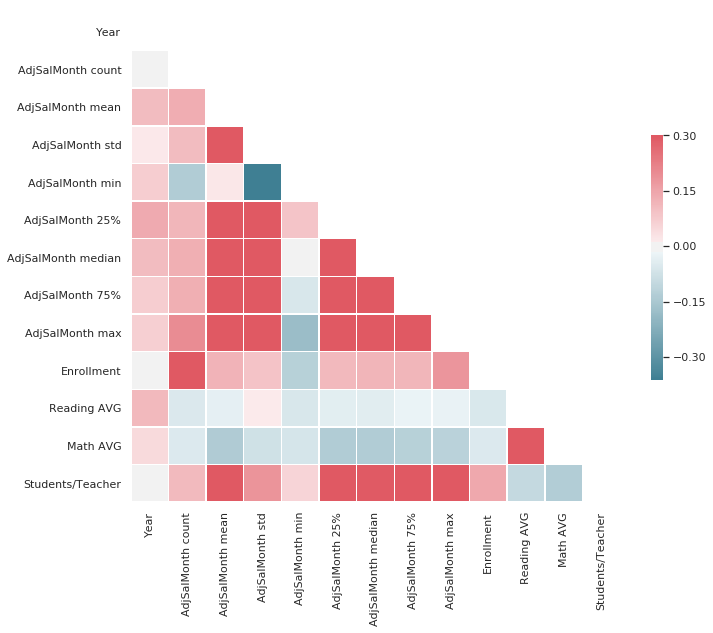

In [129]:
#heatmap
# Compute the correlation matrix
corr_mat = scores_df.corr()

# Generate a mask for the upper triangle
mask2 = np.zeros_like(corr_mat, dtype=np.bool)
mask2[np.triu_indices_from(mask2)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask2, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0.5, 1.0, 'Distribution of Average Math Scores')

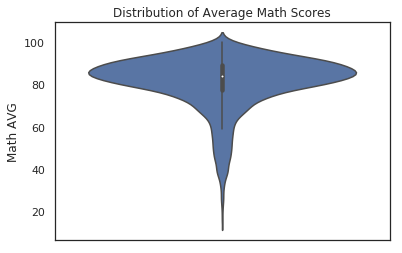

In [130]:
sns.violinplot(y='Math AVG', data=scores_df).set_title('Distribution of Average Math Scores')


Text(0.5, 1.0, 'Distribution of Average Reading Scores')

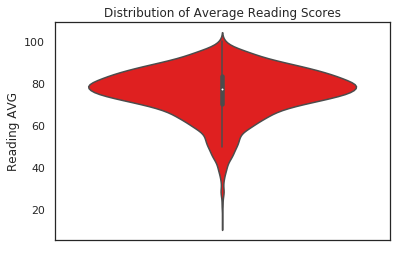

In [131]:
sns.violinplot(y='Reading AVG', data=scores_df, color='red').set_title('Distribution of Average Reading Scores')

Text(0.5, 1.0, 'Enrollment Distribution')

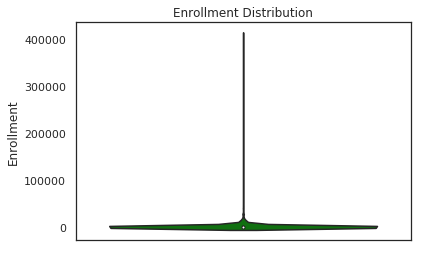

In [132]:
sns.violinplot(y='Enrollment', data=scores_df, color='green').set_title('Enrollment Distribution')

Text(0.5, 1.0, 'Student:Teacher Ratio Distribution')

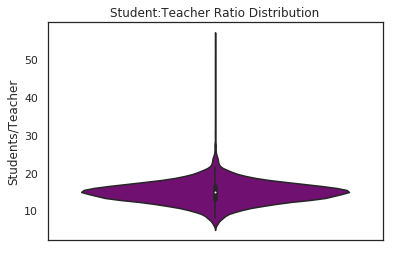

In [133]:
sns.violinplot(y='Students/Teacher', data=scores_df, color='purple').set_title('Student:Teacher Ratio Distribution')

**MODEL CREATION**

---



In [168]:
### TEST TRAIN VALIDATION SPLIT ###

num_instances = df.shape[0]

X = df_num['CPIAdjSalary']
Y = df_num.drop(['CPIAdjSalary', 'salary', 'AdjSalMonth', 'SalMonth'], axis=1)

# Creating the train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)  

# Splitting df_train into the train and then holding some out for validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.143)

print("Confirming Splits...")
print("X_TRAIN: " + str(X_train.shape[0]) + " = " + str(round((X_train.shape[0]/num_instances)*100, 2)) + "%")
print("X_TEST: " + str(X_test.shape[0]) + " = " + str(round((X_test.shape[0]/num_instances)*100, 2)) + "%")
print("X_VALIDATION: " + str(X_val.shape[0]) + " = " + str(round((X_val.shape[0]/num_instances)*100, 2)) + "%")

print()
print("Y_TRAIN: " + str(Y_train.shape[0]) +  ", " + str(Y_test.shape[1]) + " = " + str(round((Y_train.shape[0]/num_instances)*100, 2)) + "%")
print("Y_TEST: " + str(Y_test.shape[0]) +  ", " + str(Y_test.shape[1]) + " = " + str(round((Y_test.shape[0]/num_instances)*100, 2)) + "%")
print("Y_VALIDATION: " + str(Y_val.shape[0]) +  ", " + str(Y_val.shape[1]) + " = " + str(round((Y_val.shape[0]/num_instances)*100, 2)) + "%")

# This is a *close* Train/Test/Validation split of 60/30/10

# X_train, Y_train is the data set we should train all the models with
# X_test, Y_test is the data we will be testing our models on to assess accuracy
# X_val, Y_val is the validation data set 

Confirming Splits...
X_TRAIN: 777136 = 59.99%
X_TEST: 388634 = 30.0%
X_VALIDATION: 129674 = 10.01%

Y_TRAIN: 777136, 41 = 59.99%
Y_TEST: 388634, 41 = 30.0%
Y_VALIDATION: 129674, 41 = 10.01%


In [0]:
### FEATURE SELECTION ###

# We will need to flesh this out more.

In [169]:
X_train

863766      53933.889489
251840      87713.415810
984513      97113.656543
102760      55914.590897
704720     136711.487280
1164143     57680.732783
1475429     50429.172906
435925     100478.532513
1528801    114028.379115
778706      60137.881853
1331854     57477.819072
874132      56502.704991
1610053     93686.779899
1471684     50644.891057
1533524     41357.358306
1006234     94440.106875
1163697     65841.047873
376638      66324.514316
1482407     70429.368848
1478092    112560.968588
1584453     62413.031143
578477      88528.442360
864353      56367.547276
239097      57031.426571
219351      67883.738197
730129     102712.384207
414335      54959.352176
886985     104887.830159
623628      79607.657095
920649      47910.357049
               ...      
1041035    107036.856595
814332     150172.926531
849832     116943.999488
935520      78699.291728
709880     111343.291592
1488384    104563.023281
974246      63368.802450
431702      47742.881314
147483      96809.075330


In [170]:
### LINEAR REGRESSION ###

linear_model = LinearRegression()
linear_model.fit(Y_train,X_train)
r_squared = linear_model.score(Y_train, X_train)
print("COEFFICIENT OF DETERMINATION", r_squared)

COEFFICIENT OF DETERMINATION 0.6772423960702052


In [171]:
### Decision Tree ###
from sklearn.tree import DecisionTreeRegressor
rgr = DecisionTreeRegressor(criterion='mse', splitter='best', max_depth=3, min_samples_split=2, min_samples_leaf=1, max_features=None)
rgr.fit(Y_train,X_train)
scores_ACC = rgr.score(Y_train,X_train)                                                                                                                          
print('Decision Tree Accuracy:', scores_ACC)

Decision Tree Accuracy: 0.5335816738192367


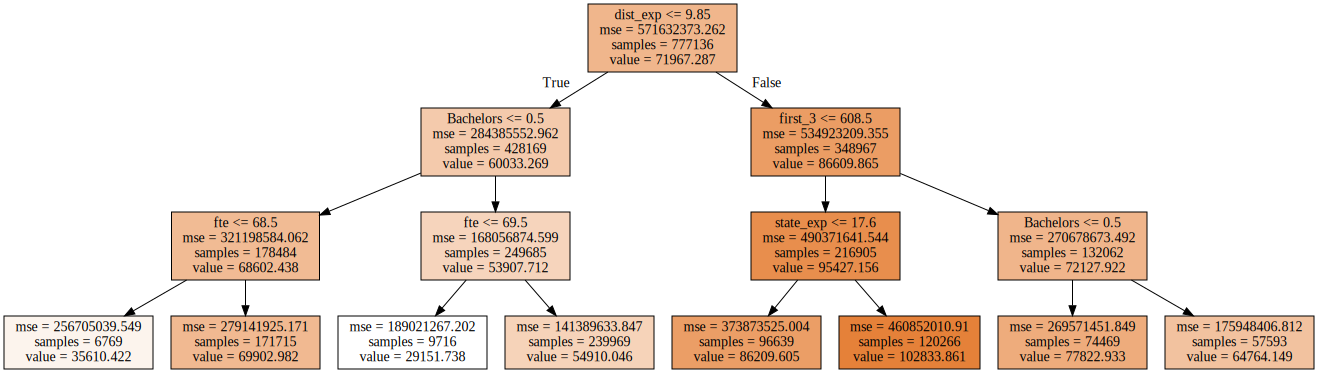

In [172]:
from graphviz import Source
from sklearn import tree
from IPython.display import SVG

graph = Source(tree.export_graphviz(rgr, out_file=None,filled = True,feature_names=Y_train.columns.values))
display(SVG(graph.pipe(format='svg')))

In [0]:
### LOGISTIC REGRESSION ###

In [0]:
### K-MEANS CLUSTERING ###

In [0]:
### RANDOM FORESTS ###